In [1]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.backbone.utils import FromBuffer , CutPSD, NormLayer
import matplotlib.pyplot as plt
from torch import nn 
%load_ext autoreload
%autoreload 2

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [2]:
import pandas as pd 
import sqlite3
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
conn = sqlite3.connect(db_path)
# Read the 'meteo_data' table into a DataFrame
data_meteo = pd.read_sql('SELECT * FROM meteo_data', conn)
df_plot_meteo = data_meteo.pivot_table(index='date', columns='channel_name', values='value')
df_plot_meteo.index = pd.to_datetime(df_plot_meteo.index)
# Close the database connection
conn.close()

In [3]:
import numpy as np
from pathlib import Path
from torch import nn
freq_axis = np.linspace(0, 825.5, 8197)
columns= ['psd','level','direction']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))] + [nn.Identity()]*2
query_key = f'''
    SELECT id FROM data
    WHERE date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
    AND sensor = "accel"
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='data', columns=columns,transform_func=transform_func, query_key=query_key, batch_size=128, return_dict=True, cached=True,num_workers=16)


In [4]:
data_loader.setup()

In [5]:
for batch in data_loader.train_dataloader():
    break

In [6]:
import torch
import torch.nn as nn
from hannover_pylon.modelling.backbone import utils as ut

class OneToOneAutoEncoder(nn.Module):
    def __init__(self, psd_length=1490, hidden_dims=[512, 128, 64], latent_dim=32):
        """
        A one-to-one autoencoder for a single sensor.
        
        Args:
            psd_length (int): Length of the PSD vector.
            hidden_dims (list): Hidden layer sizes for the encoder.
            latent_dim (int): Dimension of the latent space.
        """
        super().__init__()
        # Encoder: input (PSD vector) -> hidden layers -> latent vector
        self.encoder = ut.build_layers(
            hidden_dims=[psd_length] + hidden_dims,
            activation_list=['relu'] * len(hidden_dims)+[None],
            batch_norm=False,
        )
        self.latent_layer = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder: latent vector -> hidden layers (reverse order) -> reconstruction of PSD vector
        decoder_dims = hidden_dims[::-1]
        self.decoder = ut.build_layers(
            hidden_dims=[latent_dim] + decoder_dims + [psd_length],
            activation_list=['relu'] * (len(decoder_dims)) + ['sigmoid'],
            batch_norm=False,
        )
        self.device_ = None
        
    def forward(self, x_dict):
        """
        Args:
            x_dict (dict): Dictionary containing the input data under key "psd".  
                           Expected shape of x_dict["psd"]: (B, psd_length)
        
        Returns:
            dict: Contains keys:
                - "reconstruction": the reconstructed PSD vector (B, psd_length)
                - "latent": the latent vector (B, latent_dim)
        """
        # Extract the PSD vector from the dict.
        x = x_dict["psd"]
        # to device 
        if self.device_ is None :
            self.device_ = next(self.parameters()).device
        x = x.to(self.device_)
        encoded = self.encoder(x)
        latent = self.latent_layer(encoded)
        reconstruction = self.decoder(latent)
        return {"reconstruction": reconstruction, "latent": latent}
    
import pytorch_lightning as pl

class OneToOneTrainingModule(pl.LightningModule):
    def __init__(self, psd_length=1490, hidden_dims=[512,128,64], latent_dim=32, lr=1e-3):
        super().__init__()
        self.model = OneToOneAutoEncoder(psd_length=psd_length, hidden_dims=hidden_dims, latent_dim=latent_dim)
        self.loss_fn = nn.MSELoss()
        self.lr = lr
        self.save_hyperparameters(ignore="model")
        
    def forward(self, x):
        return self.model(x)
    def _common_step(self, batch, batch_idx):
        output = self(batch)
        reconstruction = output["reconstruction"]
        loss = self.loss_fn(reconstruction, batch["psd"])
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [6]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch

# Instantiate your Lightning module.
model = OneToOneTrainingModule(
    psd_length=1490,
    hidden_dims=[512,256,128],
    latent_dim=4,
    lr=1e-3
)


# Define a model checkpoint callback to save the best models.
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',              # Monitor the validation loss.
    dirpath='checkpoints',           # Directory to save checkpoints.
    filename='autoencoder-{epoch:02d}-{val_loss:.4f}', 
    save_top_k=3,                    # Save the 3 best models.
    mode='min'
)

# Define an early stopping callback (optional).
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=True,
    mode='min'
)

# Create the Trainer instance.
trainer = Trainer(
    max_epochs=150,
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator='gpu'
)

# Start training.
trainer.fit(model,data_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_

DataModule already setup


/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 986/986 [00:05<00:00, 188.07it/s, v_num=176, train_loss=0.000632, val_loss=0.000665]

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 45. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.001


Epoch 1: 100%|██████████| 986/986 [00:05<00:00, 171.05it/s, v_num=176, train_loss=0.000625, val_loss=0.000534]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 2: 100%|██████████| 986/986 [00:05<00:00, 172.74it/s, v_num=176, train_loss=0.000376, val_loss=0.000346]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 3: 100%|██████████| 986/986 [00:05<00:00, 174.43it/s, v_num=176, train_loss=0.000352, val_loss=0.000288]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 5: 100%|██████████| 986/986 [00:05<00:00, 177.83it/s, v_num=176, train_loss=0.00023, val_loss=0.000265] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 986/986 [00:05<00:00, 170.87it/s, v_num=176, train_loss=0.000196, val_loss=0.000242]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 986/986 [00:06<00:00, 162.91it/s, v_num=176, train_loss=0.00031, val_loss=0.000222] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 986/986 [00:05<00:00, 168.30it/s, v_num=176, train_loss=0.000293, val_loss=0.000215]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 986/986 [00:06<00:00, 160.11it/s, v_num=176, train_loss=0.000178, val_loss=0.000215]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 986/986 [00:06<00:00, 163.19it/s, v_num=176, train_loss=0.000192, val_loss=0.000209]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 986/986 [00:06<00:00, 162.99it/s, v_num=176, train_loss=0.000169, val_loss=0.000205]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 986/986 [00:06<00:00, 158.49it/s, v_num=176, train_loss=0.000188, val_loss=0.000202]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 14: 100%|██████████| 986/986 [00:06<00:00, 164.31it/s, v_num=176, train_loss=0.000153, val_loss=0.000194]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 986/986 [00:05<00:00, 164.46it/s, v_num=176, train_loss=0.00026, val_loss=0.000189] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 986/986 [00:05<00:00, 167.56it/s, v_num=176, train_loss=0.000181, val_loss=0.000184]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 986/986 [00:05<00:00, 171.18it/s, v_num=176, train_loss=0.000217, val_loss=0.000183]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 986/986 [00:05<00:00, 171.82it/s, v_num=176, train_loss=0.000153, val_loss=0.000175]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 986/986 [00:05<00:00, 169.05it/s, v_num=176, train_loss=0.00017, val_loss=0.000173] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 986/986 [00:06<00:00, 159.83it/s, v_num=176, train_loss=0.00017, val_loss=0.000171] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 986/986 [00:05<00:00, 170.04it/s, v_num=176, train_loss=0.000156, val_loss=0.000166]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 986/986 [00:05<00:00, 169.55it/s, v_num=176, train_loss=0.00017, val_loss=0.000164] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 986/986 [00:05<00:00, 173.02it/s, v_num=176, train_loss=0.000164, val_loss=0.000161]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 986/986 [00:05<00:00, 172.29it/s, v_num=176, train_loss=0.000119, val_loss=0.000158]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 986/986 [00:06<00:00, 161.45it/s, v_num=176, train_loss=0.000137, val_loss=0.000157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 986/986 [00:06<00:00, 156.96it/s, v_num=176, train_loss=0.000123, val_loss=0.000154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 986/986 [00:06<00:00, 158.94it/s, v_num=176, train_loss=0.000127, val_loss=0.000154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 52: 100%|██████████| 986/986 [00:05<00:00, 164.68it/s, v_num=176, train_loss=0.000136, val_loss=0.00015] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 60: 100%|██████████| 986/986 [00:05<00:00, 164.93it/s, v_num=176, train_loss=0.000142, val_loss=0.00015] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 64: 100%|██████████| 986/986 [00:06<00:00, 158.27it/s, v_num=176, train_loss=0.000158, val_loss=0.000149]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 72: 100%|██████████| 986/986 [00:06<00:00, 161.55it/s, v_num=176, train_loss=0.000159, val_loss=0.000148]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 75: 100%|██████████| 986/986 [00:06<00:00, 164.29it/s, v_num=176, train_loss=0.000124, val_loss=0.000146]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 85: 100%|██████████| 986/986 [00:06<00:00, 160.16it/s, v_num=176, train_loss=0.000125, val_loss=0.000152]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 85: 100%|██████████| 986/986 [00:06<00:00, 160.13it/s, v_num=176, train_loss=0.000125, val_loss=0.000152]


In [ ]:
best_model_path = checkpoint_callback.best_model_path
# print mse loss

print(checkpoint_callback.best_model_score.item())
best_model = OneToOneTrainingModule.load_from_checkpoint(best_model_path)

0.00014636288688052446


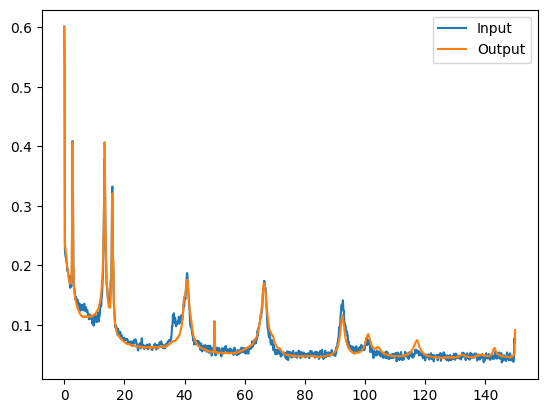

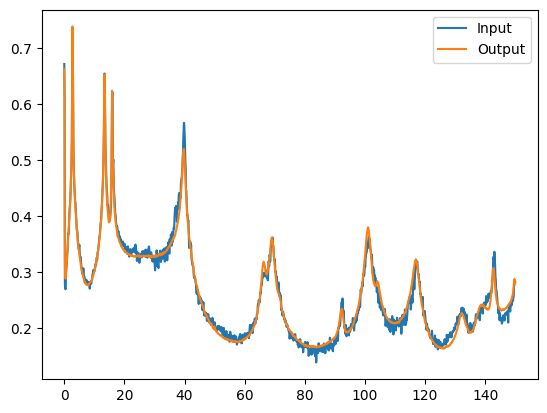

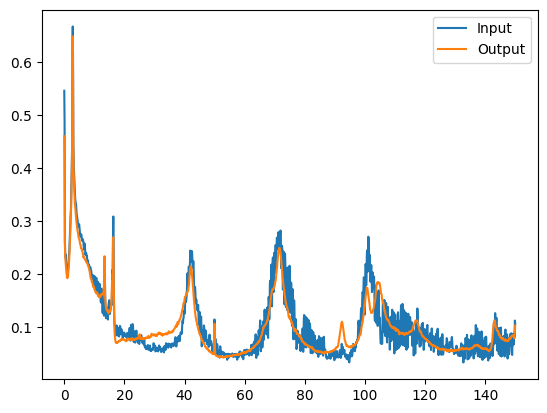

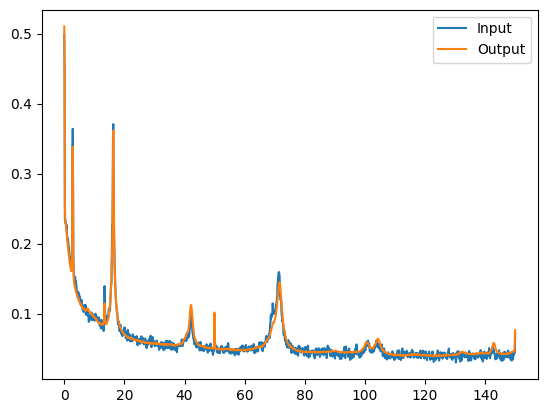

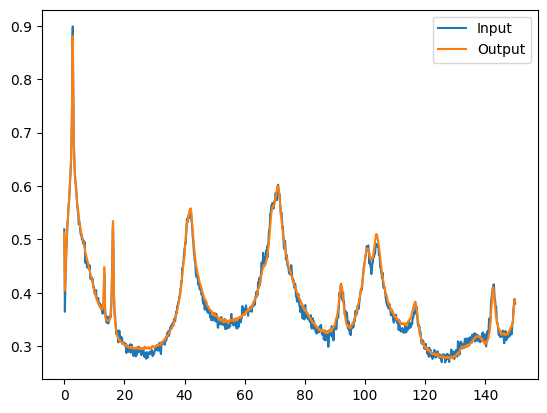

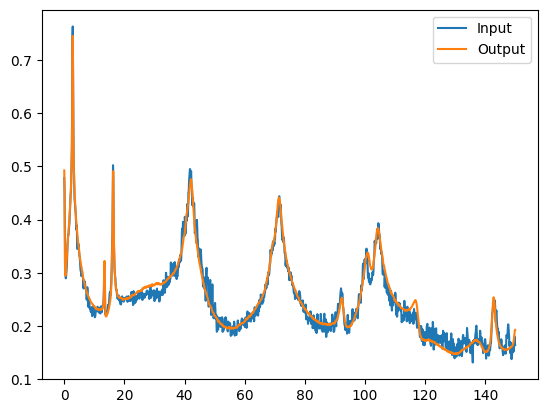

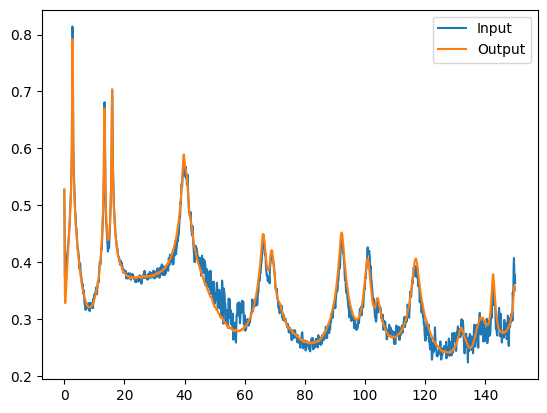

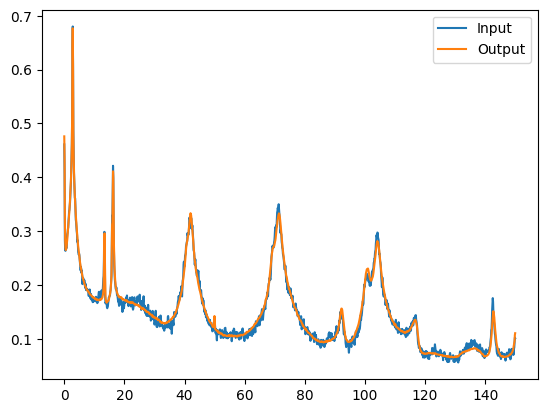

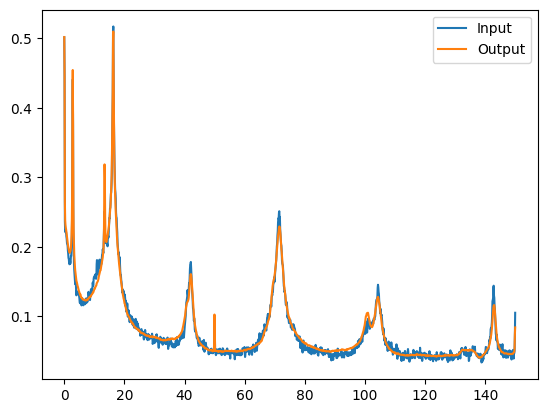

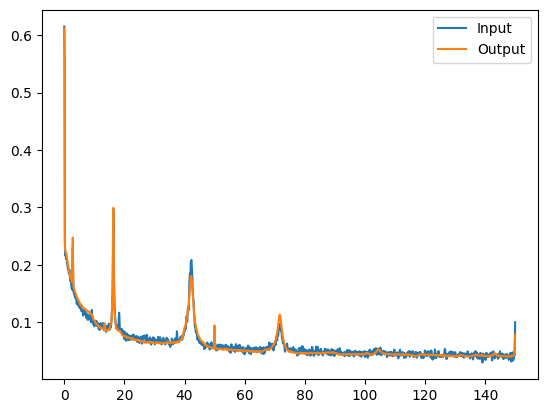

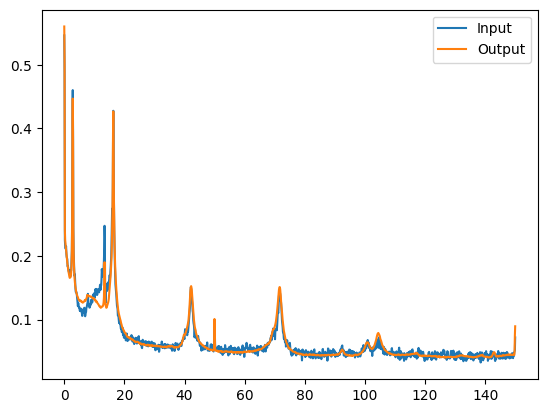

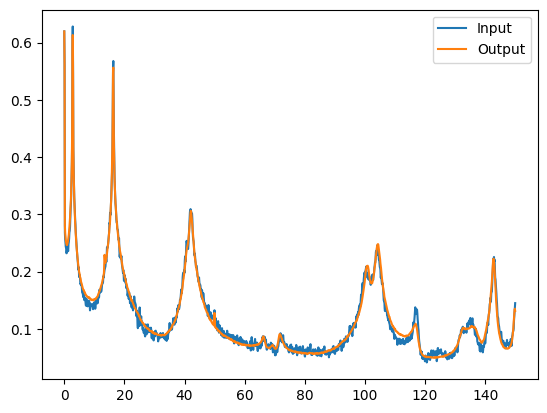

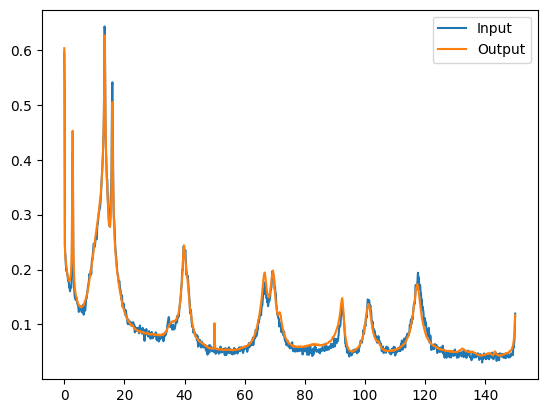

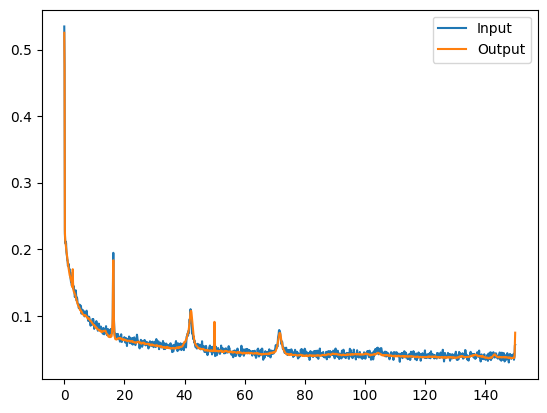

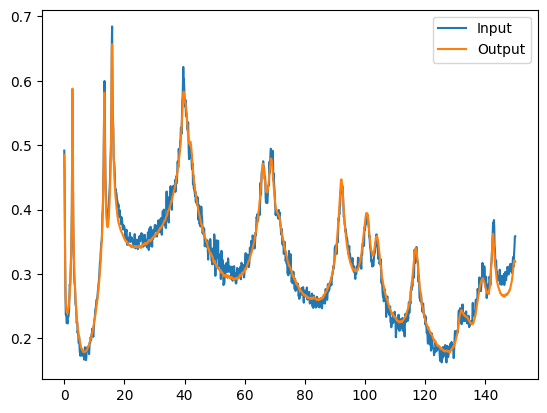

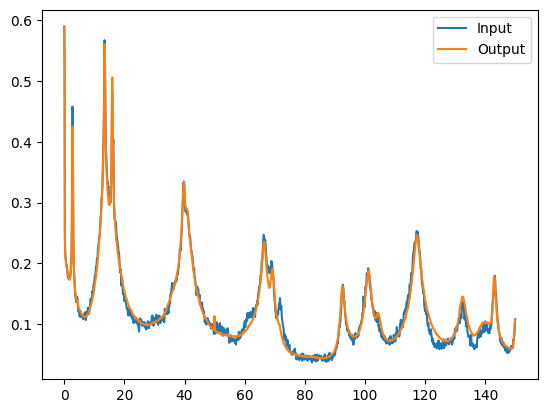

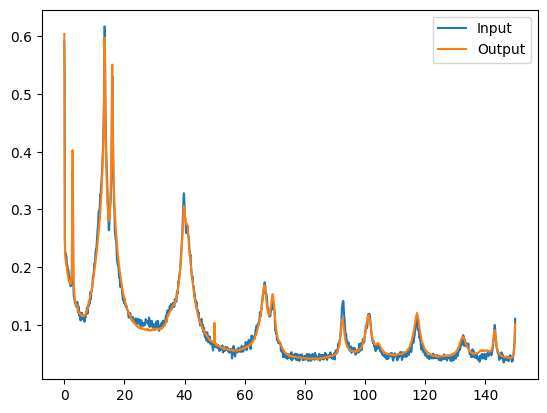

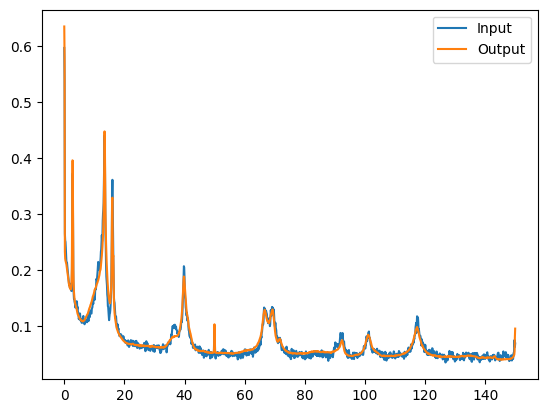

In [9]:
best_model.eval()
batch = next(iter(data_loader.val_dataloader()))
psd_out = best_model(batch)
psd_in = batch['psd']
psd_out = psd_out['reconstruction']                                        

for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:1490], psd_in[i].detach().numpy(), label='Input')
    plt.plot(freq_axis[0:1490], psd_out[i].cpu().detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()

In [10]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.device = next(model.parameters()).device

    def mse(self, x_dict):
        # Ensure the input tensor is on the same device as the model.
        x = x_dict["psd"].to(self.device)
        with torch.no_grad():
            # The autoencoder returns a dict; we extract the reconstruction.
            out = self.model({"psd": x})
        x_hat = out["reconstruction"]
        
        # Compute the element-wise squared error.
        error = (x - x_hat) ** 2
        
        # Compute the 90th quantile along the feature dimension (dim=1).
        quantile_error = torch.quantile(error, q=0.9, dim=1)
        return quantile_error

    def forward(self, x_dict):
        return self.mse(x_dict)

In [1]:
best_model
detector = Detector(best_model)

# Get a batch from your data loader (which yields a dict with key "psd").
batch = next(iter(data_loader.val_dataloader()))

# Compute the damage metric for this batch.
damage_metric = detector(batch)  # returns a tensor of shape (B,)

print("Damage metric (90th percentile reconstruction error) per sample:")
print(damage_metric)

NameError: name 'best_model' is not defined

In [12]:
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['psd','direction','level','date']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))] + [nn.Identity()]*3
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='data',
                               columns=columns,transform_func=transform_func,
                               query_key=query_key, batch_size=24000, return_dict=True, cached=False)
data_loader.setup()


In [13]:
import pandas as pd
import torch

# Initialize an empty list to store DataFrames.
df_list = []

# Loop over all batches from the data loader.
for batch in data_loader.all_dataloader():
    # Unpack the batch. (Assuming the order is: psds, dates, directions, levels)
    psds, dates, directions, levels = batch['psd'], batch['date'], batch['direction'], batch['level']
    print(dates[0])
    # Run the detector. The detector expects a dict with key "psd".
    mse_vals = detector(batch)
    
    # Convert the mse_vals tensor to a NumPy array.
    mse_vals_np = mse_vals.cpu().numpy() if mse_vals.is_cuda else mse_vals.numpy()
    
    # Ensure dates, directions, and levels are in NumPy array format.
    dates_np = dates.cpu().numpy() if isinstance(dates, torch.Tensor) else dates
    directions_np = directions.cpu().numpy() if isinstance(directions, torch.Tensor) else directions
    levels_np = levels.cpu().numpy() if isinstance(levels, torch.Tensor) else levels
    
    # Create a temporary DataFrame for the current batch.
    df_temp = pd.DataFrame({
        'date': dates_np,
        'mse': mse_vals_np,
        'direction': directions_np,
        'level': levels_np
    })
    
    # Append the temporary DataFrame to the list.
    df_list.append(df_temp)

# Concatenate all the DataFrames in the list into a single DataFrame.
df_res = pd.concat(df_list, axis=0, ignore_index=True)

# Now you can work with df_res as needed.
print(df_res.head())


2020-08-01 00:02:00
2020-08-10 06:57:00
2020-08-19 13:42:00
2020-08-28 20:37:00
2020-09-07 04:22:00
2020-09-16 10:52:00
2020-09-25 17:37:00
2020-10-04 23:42:00
2020-10-18 14:37:00
2020-10-27 22:16:00
2020-11-06 05:41:00
2020-11-15 17:45:00
2020-11-25 00:00:00
2020-12-04 06:15:00
2020-12-13 12:40:00
2020-12-22 18:55:00
2021-01-01 01:30:00
2021-01-10 07:55:00
2021-01-24 17:17:00
2021-02-02 23:52:00
2021-02-12 06:17:00
2021-02-21 13:03:00
2021-03-02 19:28:00
2021-03-12 01:43:00
2021-03-21 08:28:00
2021-03-30 17:11:00
2021-04-08 23:16:00
2021-04-18 05:31:00
2021-04-27 11:36:00
2021-05-06 18:22:00
2021-05-16 01:07:00
2021-05-25 07:22:00
2021-06-03 13:47:00
2021-06-12 21:12:00
2021-06-22 05:14:00
2021-07-01 13:12:00
2021-07-10 19:27:00
2021-07-20 01:42:00
2021-07-29 08:07:00
                  date       mse direction  level
0  2020-08-01 00:02:00  0.000131         x      1
1  2020-08-01 00:02:00  0.000199         y      1
2  2020-08-01 00:02:00  0.000100         x      2
3  2020-08-01 00:02:

In [14]:
import pandas as pd

# Convert the date column to datetime.
df_res['date'] = pd.to_datetime(df_res['date'])

# Define training period boundaries using your settings.
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end   = pd.to_datetime(settings.state.healthy_train.end)

def normalize_sensor(group):
    """
    For a given sensor group, normalize the 'mse' column using the training period's min and max.
    """
    # Create a mask for rows within the training period.
    train_mask = (group['date'] >= train_start) & (group['date'] <= train_end)
    
    if train_mask.any():
        train_min = group.loc[train_mask, 'mse'].quantile(0.01)
        train_max = group.loc[train_mask, 'mse'].quantile(0.98)
        if train_max - train_min != 0:
            group['mse'] = (group['mse'] - train_min) / (train_max - train_min)
        else:
            group['mse'] = 0.0  # Avoid division by zero.
    else:
        # If no training data is available for this sensor group, you can decide to leave it as is or set to NaN.
        group['mse'] = group['mse']  # or: group['mse'] = np.nan
    return group

# Group the DataFrame by sensor. Here, we assume that 'direction' indicates the sensor.
df_normalized = df_res.groupby('direction', group_keys=False).apply(normalize_sensor)

# Display the first few rows of the normalized DataFrame.
print(df_normalized.head())


                 date       mse direction  level
0 2020-08-01 00:02:00  0.060121         x      1
1 2020-08-01 00:02:00  0.068866         y      1
2 2020-08-01 00:02:00  0.037985         x      2
3 2020-08-01 00:02:00  0.078571         y      2
4 2020-08-01 00:02:00  0.037939         x      3


/tmp/ipykernel_945962/221262152.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_normalized = df_res.groupby('direction', group_keys=False).apply(normalize_sensor)


In [32]:
df_normalized['mse'].quantile(0.9)

np.float64(5.552941989898681)

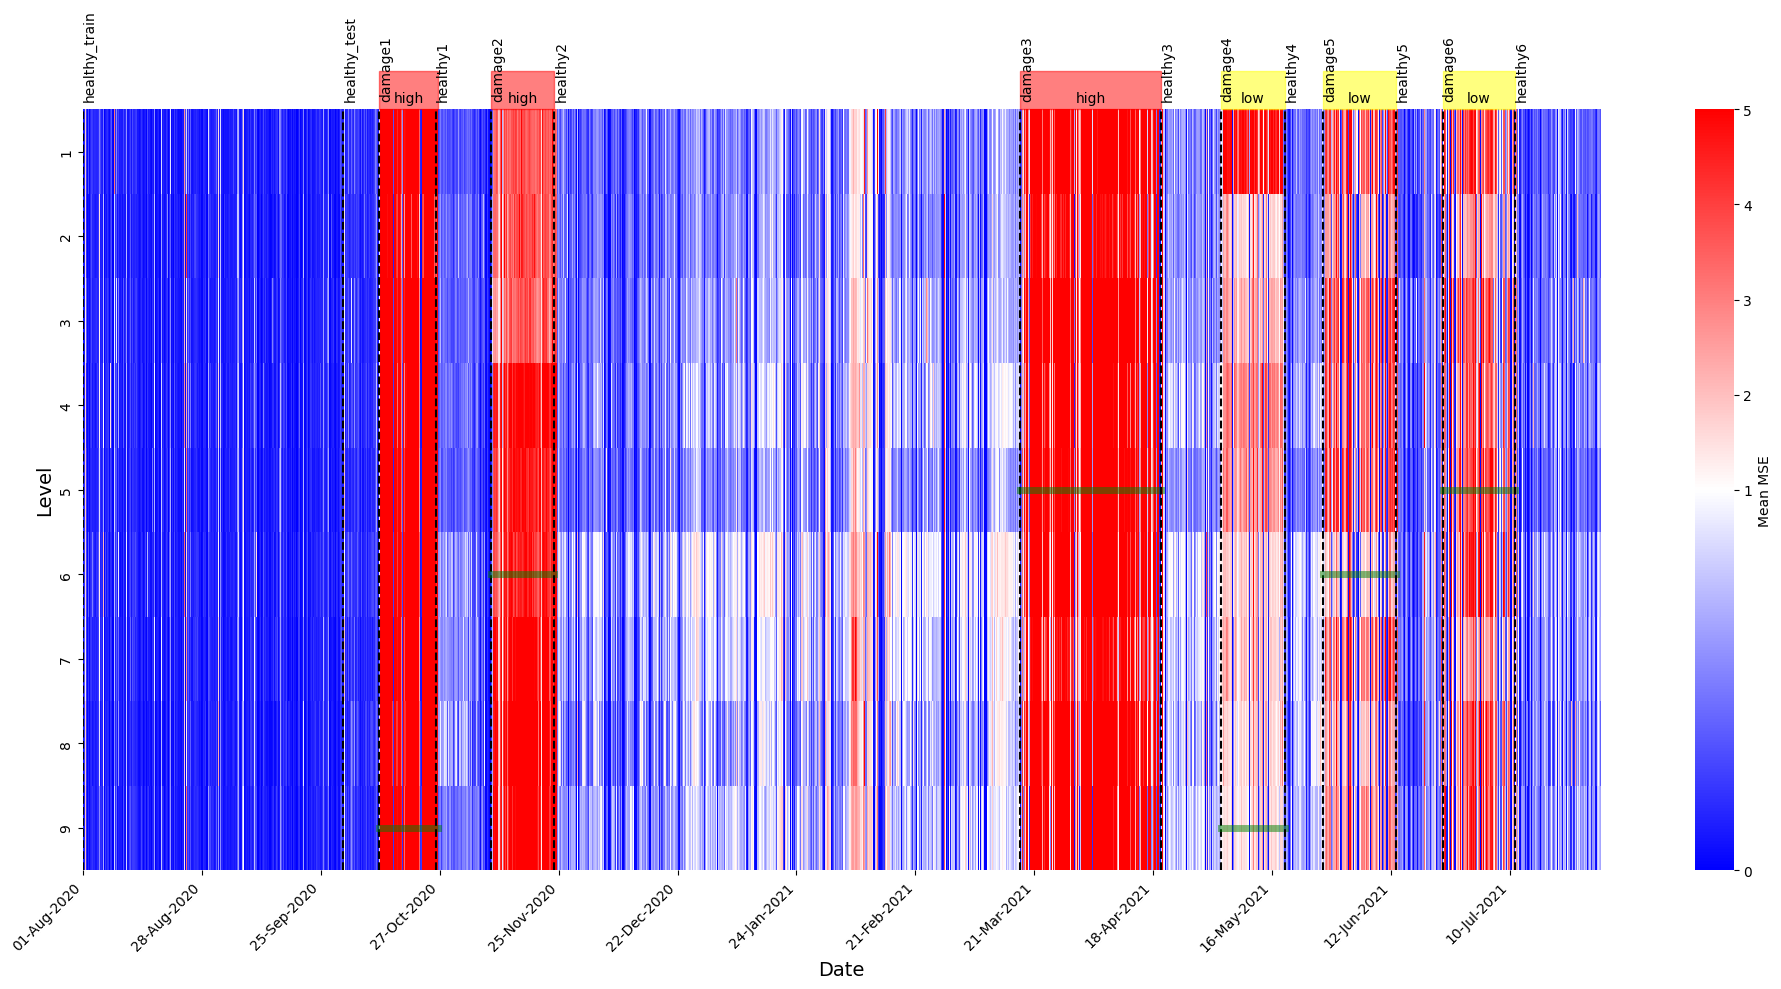

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors


# Ensure the date column is in datetime format.
df_normalized['date'] = pd.to_datetime(df_normalized['date'])

# Optionally, select a single sensor direction for the control chart.
# For instance, if you want to focus on the "y" direction:
df_control = df_normalized[df_normalized['direction'] == 'y']

# =============================================================================
# 2. Pivot the DataFrame for a Heatmap
# =============================================================================
# Create a pivot table with sensor level as the index, date as columns, and mean mse as values.
df_pivot = df_control.pivot_table(index='level', columns='date', values='mse', aggfunc='mean')
#df_pivot = df_pivot.rolling('1h').mean().T
# Ensure the pivot table's columns are datetime objects.
df_pivot.columns = pd.to_datetime(df_pivot.columns)

# =============================================================================
# 3. Create a Custom Date Formatter for the x-axis
# =============================================================================
def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        try:
            idx = int(x)
            if 0 <= idx < len(column_dates):
                return column_dates[idx].strftime('%d-%b-%Y')
            return ''
        except Exception:
            return ''
    return FuncFormatter(custom_date_format)

# =============================================================================
# 4. Define Custom Colormap and Norm
# =============================================================================
# Create a custom colormap from blue to white to red.
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_bwr', ['blue', 'white', 'red'])
# Use TwoSlopeNorm to center the colormap at 1, with vmin=0 and vmax=2.
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=5)

# =============================================================================
# 5. Plot the Control Chart (Heatmap)
# =============================================================================
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(
    df_pivot,
    cmap=custom_cmap,                # Use the custom colormap.
    norm=norm,                       # Apply the normalization so that white is at 1.
    cbar_kws={'label': 'Mean MSE'},   # Label for the color bar.
    ax=ax
)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)

# Create a list of dates from the pivot table columns.
dates_list = list(df_pivot.columns)
ax.xaxis.set_major_formatter(create_date_formatter(dates_list))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Limit the number of x-axis ticks

# Rotate x-axis labels for better readability.
plt.xticks(rotation=45, ha='right')

# =============================================================================
# 6. (Optional) Annotate Events on the Chart
# =============================================================================
# If you have events defined in your settings, you can annotate the plot.
# For example, if events are stored as a dictionary in settings.state:
# events = {
#     "Event1": {"start": "2020-01-10", "end": "2020-01-12", "closest_sensor": 3, "severity": "high"},
#     "Event2": {"start": "2020-02-05", "end": "2020-02-07", "closest_sensor": 2, "severity": "low"}
# }
events = settings.state.to_dict()
for event_i, event_info in events.items():
    start = pd.to_datetime(event_info['start'])
    end = pd.to_datetime(event_info['end'])
    # Find approximate x-axis indices corresponding to start and end dates.
    idx_start = np.searchsorted(df_pivot.columns, start)
    idx_end = np.searchsorted(df_pivot.columns, end)
    
    # Draw a vertical line at the event start.
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw a horizontal line at the sensor level closest to the event (if provided).
    level = event_info.get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start/len(df_pivot.columns), xmax=idx_end/len(df_pivot.columns),
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a rectangle above the plot indicating severity.
    severity = event_info.get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        box_height = 0.05  # Height of the severity box.
        ax.add_patch(Rectangle(
            (idx_start, 1),       # Position above the plot.
            width=idx_end - idx_start,
            height=box_height,
            color=color,
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            clip_on=False
        ))
        ax.text((idx_start + idx_end) / 2, -0.1 + box_height, severity,
                ha='center', va='bottom', color='black')

# =============================================================================
# 7. Finalize and Show the Plot
# =============================================================================
plt.tight_layout()
plt.show()


In [36]:
df_normalized['sensor_name'] = df_normalized['direction'] + df_normalized['level'].astype(str)

,date,mse,direction,level,sensor_name
1,2020-08-01 00:02:00,0.068866,y,1,y1
3,2020-08-01 00:02:00,0.078571,y,2,y2
5,2020-08-01 00:02:00,0.069463,y,3,y3
7,2020-08-01 00:02:00,0.090170,y,4,y4
9,2020-08-01 00:02:00,0.105203,y,5,y5
...,...,...,...,...,...
918891,2021-07-31 23:56:00,0.129171,y,5,y5
918893,2021-07-31 23:56:00,0.155004,y,6,y6
918895,2021-07-31 23:56:00,0.147149,y,7,y7
918897,2021-07-31 23:56:00,0.128260,y,8,y8


In [85]:
import pandas as pd
import numpy as np
from sklearn.covariance import OAS

df_agg= df_normalized[df_normalized['direction']=="y"].pivot(index='date', columns='sensor_name', values='mse') 
df_agg.index = pd.to_datetime(df_agg.index)
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
train_mask = (df_agg.index >= train_start) & (df_agg.index <= train_end)
df_train = df_agg.loc[train_mask]
oas = OAS(store_precision=True, assume_centered=False)
oas.fit(df_train)
df_agg['mahal'] = np.sqrt(oas.mahalanobis(df_agg))

# --- 6. (Optional) Inspect the Results ---


In [86]:
negative_mask = df_plot_meteo['airTemperatureAt2m'] < 0

start_indices = df_plot_meteo.index[negative_mask & ~negative_mask.shift(fill_value=False)]
end_indices = df_plot_meteo.index[~negative_mask & negative_mask.shift(fill_value=False)]

# Ensure lengths match (handle open-ended cases)
if len(end_indices) < len(start_indices):
    end_indices = end_indices.append(pd.Index([df_plot_meteo.index[-1]]))

# Create a DataFrame with stardf_plot_meteot and end times of subzero temperature regions
date_subzero_temperature = pd.DataFrame({'start_time': start_indices, 'end_time': end_indices})


In [87]:
sensor_cols = df_agg.filter(regex=r'^y\d+$').columns
df_agg['mean_mse'] = df_agg[sensor_cols].mean(axis=1)



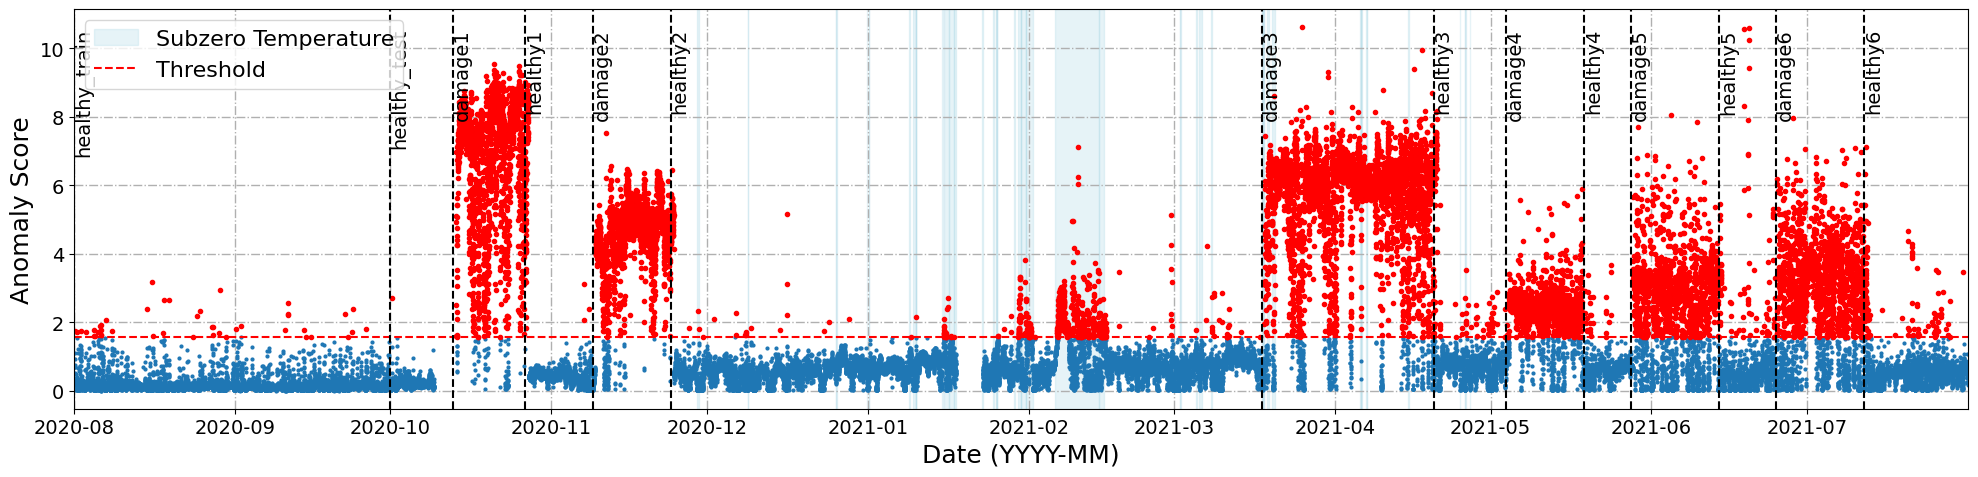

In [95]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------
# Update Publication Quality Settings with Increased Fonts
# ---------------------------
plt.rcParams.update({
    'font.size': 14,         # Base font size
    'axes.labelsize': 18,    # X and Y label font size
    'axes.titlesize': 20,    # Axes title font size
    'legend.fontsize': 16,   # Legend font size
    'xtick.labelsize': 14,   # X-tick label size
    'ytick.labelsize': 14,   # Y-tick label size
    'lines.linewidth': 1.5,
    'grid.linestyle': '-.',
    'grid.linewidth': 1,
})

# Define the column of interest (e.g., mean_mse).
col_of_interest = 'mean_mse'

# ---------------------------
# 1. Create Figure and Plot Main Control Chart
# ---------------------------
fig, ax = plt.subplots(figsize=(20, 5))

# Plot anomaly scores as individual points.
ax.plot(
    df_agg.index, 
    df_agg[col_of_interest],
    'o', 
    markersize=2, 
    color='tab:blue', 
)

# Compute threshold (99.5th percentile over the training period).
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
df_train = df_agg.loc[train_start:train_end]
threshold = df_train[col_of_interest].quantile(0.995)

# Plot the threshold as a horizontal dashed red line.
ax.axhline(threshold, color='red', linestyle='--', label='Threshold')

# Highlight points exceeding the threshold.
exceed_mask = df_agg[col_of_interest] > threshold
ax.plot(
    df_agg.index[exceed_mask],
    df_agg.loc[exceed_mask, col_of_interest],
    'o', 
    markersize=3, 
    color='red',
)

# ---------------------------
# 2. Shade Subzero Temperature Regions
# ---------------------------
# Assume 'date_subzero_temperature' is a DataFrame with 'start_time' and 'end_time' columns.
for _, row in date_subzero_temperature.iterrows():
    ax.axvspan(
        row['start_time'], 
        row['end_time'], 
        color='lightblue', 
        alpha=0.3, 
        zorder=0
    )

# Create a patch for the legend.
subzero_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Subzero Temperature')

# ---------------------------
# 3. Add Legend and Annotate Events
# ---------------------------
# Combine existing legend handles with the subzero patch.
handles, labels = ax.get_legend_handles_labels()
handles.insert(0, subzero_patch)
labels.insert(0, 'Subzero Temperature')
ax.legend(handles, labels, loc='upper left', frameon=True)

# Annotate events from settings, if any.
for event_i, event_info in settings.state.to_dict().items():
    start = pd.to_datetime(event_info['start'])
    # Draw a vertical dashed line at the event start.
    ax.axvline(start, color='black', linestyle='--', label=f'{event_i} start')
    # Optionally, add text annotation near the top of the plot.
    ax.text(
        start, 
        ax.get_ylim()[1] * 0.95, 
        f'{event_i}', 
        rotation=90, 
        va='top', 
        ha='left'
    )

# ---------------------------
# 4. Final Touches
# ---------------------------
ax.set_xmargin(0)
ax.set_xlabel('Date (YYYY-MM)', fontsize=18)  # Increased label font size
ax.set_ylabel('Anomaly Score', fontsize=18)    # Increased label font size
ax.grid(True)

plt.tight_layout()

# Save the figure at high resolution (300 dpi) for journal publication.
plt.savefig("journal_plot.png", dpi=300)
plt.show()


In [96]:
df_plot_meteo.index = df_plot_meteo.index + pd.Timedelta(minutes=10)   
df_merge_temp = pd.merge_asof(df_agg,df_plot_meteo, 
                            left_index=True, right_index=True, direction='nearest')


In [160]:
df_merge_temp

,y1,y2,y3,y4,y5,y6,y7,y8,y9,mahal,mean_mse,airTemperatureAt2m,avgWindSpeedAt10m,globalRadiation,maxWindSpeedAt10m,precipitation,relHumidityAt2m,windDirection
date,,,,,,,,,,,,,,,,,,
2020-08-01 00:02:00,0.068866,0.078571,0.069463,0.090170,0.105203,0.079375,0.071968,0.070162,0.091431,0.627581,0.080579,18.420000,1.65,0.0,2.02,0.0,71.729996,107.400002
2020-08-01 00:12:00,0.110731,0.071178,0.104641,0.106064,0.073714,0.083891,0.078214,0.079480,0.090532,0.501430,0.088716,18.420000,1.65,0.0,2.02,0.0,71.729996,107.400002
2020-08-01 00:22:00,0.041744,0.027128,0.050829,0.035532,0.029028,0.020663,0.016785,0.016990,0.009262,0.731978,0.027551,18.130001,1.30,0.0,1.03,0.0,72.410004,130.000000
2020-08-01 00:32:00,0.033346,0.031486,0.031141,0.013759,0.006816,0.025811,0.047230,0.013382,0.012124,0.812399,0.023899,17.230000,0.25,0.0,0.00,0.0,74.199997,138.699997
2020-08-01 00:42:00,0.438335,0.163311,0.413557,0.455378,0.204234,0.565909,0.173933,0.210203,0.267300,4.245961,0.321351,17.049999,0.00,0.0,0.10,0.0,77.209999,125.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31 23:16:00,0.323573,0.335989,0.444057,0.558760,0.359699,0.678095,0.602366,0.434803,0.737514,5.027197,0.497206,NaN,1.62,NaN,1.94,NaN,NaN,142.600006
2021-07-31 23:26:00,0.329049,0.302698,0.447670,0.554852,0.329210,0.623042,0.641494,0.376359,0.654136,4.968490,0.473168,NaN,1.62,NaN,1.94,NaN,NaN,142.600006
2021-07-31 23:36:00,0.325162,0.350254,0.492243,0.577293,0.368839,0.606009,0.594443,0.423310,0.695237,4.528996,0.492532,NaN,1.62,NaN,1.94,NaN,NaN,142.600006


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example: Focus on level=1 data or a specific label. Adjust as needed.
# (If you already have df_res_level_meteo, skip re-assigning it.)
df_plot = df_merge_temp.copy()

# Drop rows missing MSE or Temperature.
df_plot = df_plot.dropna(subset=['mean_mse', 'airTemperatureAt2m'])


In [119]:
from hannover_pylon.utils.evaluation import label_dataframe_event 
df_plot['label']=label_dataframe_event(df_plot.index,events=settings.state.to_dict())
df_plot['label'].unique()

array(['healthy_train', 'healthy_test', 'damage1', 'healthy1', 'damage2',
       'healthy2', 'damage3', 'healthy3', 'damage4', 'healthy4',
       'damage5', 'healthy5', 'damage6', 'healthy6'], dtype=object)

/tmp/ipykernel_945962/1878487454.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_healthy_2.groupby('temp_bin')


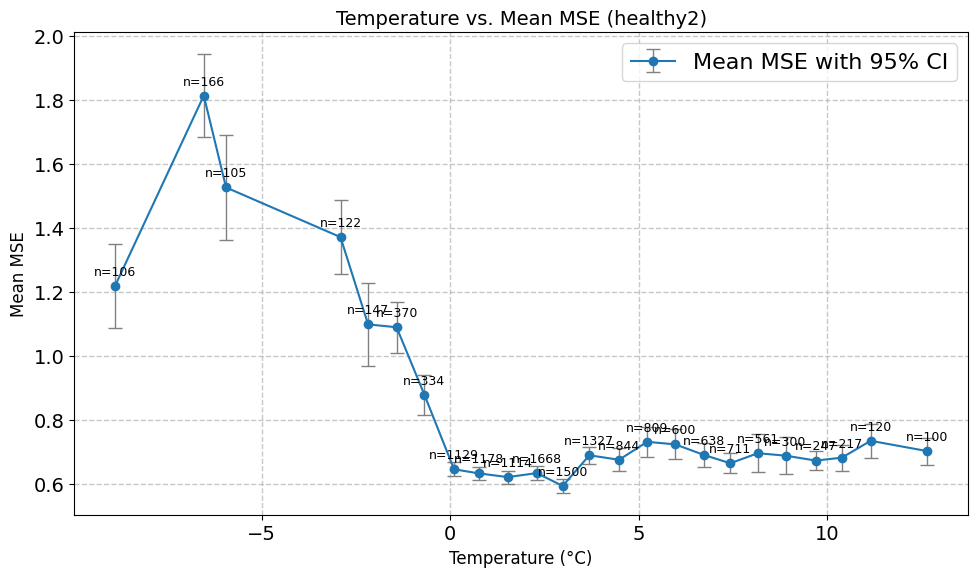

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t, pearsonr

# Assume df_plot is your merged DataFrame that contains:
# - 'airTemperatureAt2m': temperature readings,
# - 'mean_mse': the 2-hour rolling median of MSE (or your chosen aggregated anomaly score),
# - 'label': event/health label.

# Filter to the desired label (for example, "healthy2")
df_healthy_2 = df_plot[df_plot['label'] == 'healthy2'].copy()

# Create bins for temperature.
# Here we use 50 bins; adjust this number as needed.
df_healthy_2['temp_bin'] = pd.cut(df_healthy_2['airTemperatureAt2m'], bins=50)

# Group by these temperature bins.
grouped = df_healthy_2.groupby('temp_bin')

# Compute aggregated statistics per bin.
mean_temp = grouped['airTemperatureAt2m'].mean()        # Mean temperature in each bin
mean_mse = grouped['mean_mse'].mean()                     # Mean MSE in each bin
std_mse = grouped['mean_mse'].std()                       # Standard deviation of MSE
count_mse = grouped['mean_mse'].count()                   # Number of observations per bin

# Compute the standard error of the mean.
sem_mse = std_mse / np.sqrt(count_mse)

# Compute the t-critical value for a 95% confidence interval for each bin.
confidence_level = 0.95
# Degrees of freedom per bin
dof = count_mse - 1
dof[dof < 1] = np.nan  # Avoid errors for bins with too few samples
t_crit = t.ppf((1 + confidence_level) / 2, dof)

# Compute the margin of error.
margin_of_error = t_crit * sem_mse

# Filter out bins with fewer than 100 samples.
valid_bins = count_mse >= 100
mean_temp_valid = mean_temp[valid_bins]
mean_mse_valid = mean_mse[valid_bins]
margin_error_valid = margin_of_error[valid_bins]
count_valid = count_mse[valid_bins]

# Plot the binned data with error bars.
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    mean_temp_valid, 
    mean_mse_valid, 
    yerr=margin_error_valid,
    fmt='o-', capsize=5, ecolor='gray', elinewidth=1, markeredgewidth=1,
    label='Mean MSE with 95% CI'
)

ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('Mean MSE', fontsize=12)
ax.set_title('Temperature vs. Mean MSE (healthy2)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Annotate each point with the sample size.
for x, y, n in zip(mean_temp_valid, mean_mse_valid, count_valid):
    ax.annotate(f'n={int(n)}', xy=(x, y), xytext=(0, 8),
                textcoords='offset points', ha='center', fontsize=9)



plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from evaluation_lumo.evaluation import compute_tr_by_events, compute_median_variation, prepare_dataframe
from hannover_pylon.modelling.finalexp.plot import display_damage_vs_healthy_table 
scores = compute_tr_by_events(df_agg.index,df_agg['mean_mse'])[0]
display_damage_vs_healthy_table(scores)
scores = compute_median_variation(df_agg.index,df_agg['mean_mse'])    n
display_damage_vs_healthy_table(scores)


                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │       0.9589 │ healthy1             │        0.0033 │
│ damage2              │       0.9550 │ healthy2             │        0.0798 │
│ damage3              │       0.9084 │ healthy3             │        0.0512 │
│ damage4              │       0.8300 │ healthy4             │        0.0250 │
│ damage5              │       0.7005 │ healthy5             │        0.0612 │
│ damage6              │       0.7302 │ healthy6             │        0.0364 │
│                      │              │ healthy_test         │        0.0033 │
│                      │              │ healthy_train        │        0.0100 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

             Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Event                ┃  Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ no_event             │ 0.5804 │
└──────────────────────┴────────┘

                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │      49.4875 │ healthy1             │        2.8366 │
│ damage2              │      31.8385 │ healthy2             │        4.3822 │
│ damage3              │      40.2230 │ healthy3             │        4.8936 │
│ damage4              │      15.5414 │ healthy4             │        4.3233 │
│ damage5              │      17.4001 │ healthy5             │        3.1395 │
│ damage6              │      19.6030 │ healthy6             │        3.3669 │
│                      │              │ healthy_test         │        1.1582 │
│                      │              │ healthy_train        │        0.7923 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

              Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Event                ┃   Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ no_event             │ 16.3862 │
└──────────────────────┴─────────┘

                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │       0.9589 │ healthy1             │        0.0033 │
│ damage2              │       0.9550 │ healthy2             │        0.0798 │
│ damage3              │       0.9084 │ healthy3             │        0.0512 │
│ damage4              │       0.8300 │ healthy4             │        0.0250 │
│ damage5              │       0.7005 │ healthy5             │        0.0612 │
│ damage6              │       0.7302 │ healthy6             │        0.0364 │
│                      │              │ healthy_test         │        0.0033 │
│                      │              │ healthy_train        │        0.0100 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

             Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Event                ┃  Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ no_event             │ 0.5804 │
└──────────────────────┴────────┘